In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

### Load the ground-truth and evaluate the methods

In [2]:
from intestine_info import load_processed_enterocyte_data, load_original_entero_zonation
from intestine_info import get_intestine_rna_lm_genes
from io_utils import load_all_pipeline_results, load_single_result
from io_utils import save_data_to_file
from plot_utils import plot_corr_mtx
from scrna_utils import get_gene_df
from general_utils import rank_and_bin

res_dir = "/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719"
zone_vals = load_original_entero_zonation(just_vals=True)
obs_df, var_df, mtx = load_processed_enterocyte_data(res_dir)
RDIR = os.path.join(res_dir, "entero_data", "results")
method = 'graph'
mtype = 'vanilla'
ddir = os.path.join(res_dir, 'entero_data', 'results', '{}_{}'.format(method, mtype))
os.makedirs(ddir, exist_ok=True)
fns = {
    'result': os.path.join(ddir, 'method_result.pkl'),
    'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
    'embed_dict': os.path.join(ddir, 'embed_dict.pkl'),
}

[feat_viz INFO] {'Crypt': 0, 'V1': 1, 'V2': 2, 'V3': 3, 'V4': 4, 'V5': 5, 'V6': 6}


In [4]:
result = load_single_result(RDIR, method, mtype)
n_rej = len(result['rejections'])
n_genes = len(result['p_vals'])
print('Number of rejections: {} ({:.2f}%)'.format(n_rej, n_rej / n_genes * 100))
save_data_to_file(result, fns['result'], 'pkl')

Number of rejections: 6892 (71.38%)


# Fit the curve on all genes

In [5]:
from spline_utils import setup_basis, spline_fit
from general_utils import rank_and_bin, norm_mtx
# get the variable group ids
mtx = norm_mtx(mtx)
lam = result["lam_update"]
base_args = setup_basis(lam)
print(base_args)
p_fun, c_mtx = spline_fit(lam, mtx, base_args)
save_data_to_file(c_mtx, fns['coeff_mtx'], 'npy')

cr(x, knots=(0.0, 0.034))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters
Fitted 6000 parameters
Fitted 7000 parameters
Fitted 8000 parameters
Fitted 9000 parameters


# Remove low variance genes 

In [26]:
var_df.head()

,gene_ids,n_cells,mean,std,npc
0,Mrpl15,530,0.386412,0.530710,530
1,Lypla1,1045,0.999767,0.698513,1045
2,Tcea1,367,0.225788,0.401705,367
3,Atp6v1h,171,0.101006,0.292252,171
4,Rb1cc1,340,0.220587,0.425791,340


Retaining genes: 1981


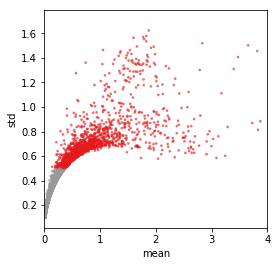

1913 out of 1981 are spatial varying


In [46]:
cut_off = 0.5
# use the cutoff to select genes to further cluster
sel = var_df['std'] > cut_off
print('Retaining genes: {}'.format(np.sum(sel)))
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.scatter(var_df['mean'], var_df['std'], c=sel*-1, 
           s=3, cmap='Set1', alpha =0.5)
ax.set_xlabel('mean')
ax.set_ylabel('std')
ax.set_xlim(0, 4)
plt.show()

high_var_idx = var_df.loc[sel].index.values
cor_sel_idx = result['rejections']
int_size = set(high_var_idx).intersection(set(cor_sel_idx))
print('{} out of {} are spatial varying'.format(len(int_size), len(high_var_idx)))

In [78]:
from intestine_info import load_gene_set_clusters
from plot_utils import plot_venn

kmtx, kdf = load_gene_set_clusters(var_df)
gset = {}
gset['moor_sel'] = set(kdf.index)
gset['high_var'] = set(var_df.loc[sel]['gene_ids'])
gset['space_var'] = set(var_df.loc[result['rejections']]['gene_ids'])
use_df = var_df.loc[sel]
use_df = use_df.loc[use_df.index.isin(result['rejections'])]
print(use_df.shape)

(1913, 5)


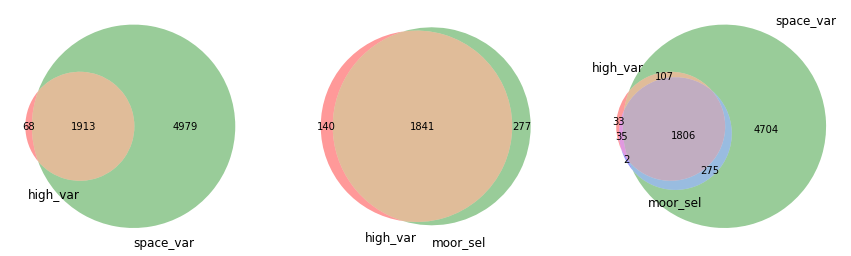

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_venn(gset, ['high_var', 'space_var'], ax=axes[0])
plot_venn(gset, ['high_var', 'moor_sel'], ax=axes[1])
plot_venn(gset, ['high_var', 'space_var', 'moor_sel'], ax=axes[2])
plt.show()

In [53]:
use_df.head()

,gene_ids,n_cells,mean,std,npc
0,Mrpl15,530,0.386412,0.530710,530
1,Lypla1,1045,0.999767,0.698513,1045
14,Arfgef1,732,0.559252,0.594950,732
16,Tram1,707,0.536192,0.579412,707
20,Rpl7,1009,1.524548,1.203265,1009


In [54]:
# our pipeline
import umap
uobj = umap.UMAP(random_state=10101)
u_mtx = c_mtx[use_df.index, :]
print("input dimension: {}".format(u_mtx.shape))
embedding = uobj.fit_transform(u_mtx)

input dimension: (1913, 5)


In [56]:
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

A = uobj.graph_
n_eigs = 10
L = csgraph.laplacian(A)
eigenvalues, eigenvectors = eigsh(L, which='SM', k=n_eigs)

In [57]:
from sklearn.cluster import KMeans
X = eigenvectors[:, 1:]
df = pd.DataFrame()
for n_clust in [4, 5, 6, 7, 8]:
    kmeans = KMeans(n_clusters=n_clust, random_state=0).fit(X)
    labs = kmeans.labels_
    name = 'k_{}'.format(n_clust)
    df[name] = labs
    print(name)

k_4
k_5
k_6
k_7
k_8


In [83]:
# use_df['moor_clust'] = -1
ndf = kdf.loc[kdf['orig_idx'].isin(use_df.index)]
# use_df['moor_clust'] = -1
vals = pd.Series(-1*np.ones(use_df.shape[0]), index=use_df.index).astype(int)
vals[ndf['orig_idx']] = ndf['clust_idx']
use_df['moor_clust'] = vals
# ndf.index = orig_id

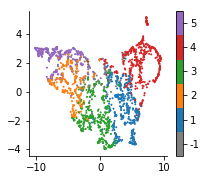

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(3,2.6))    
lut = get_sim_color_map(vals, palette='tab10')
plot_scatter_discrete(embedding, vals, cols=lut, ax=ax, ms=1)
plt.tight_layout()
plt.show()

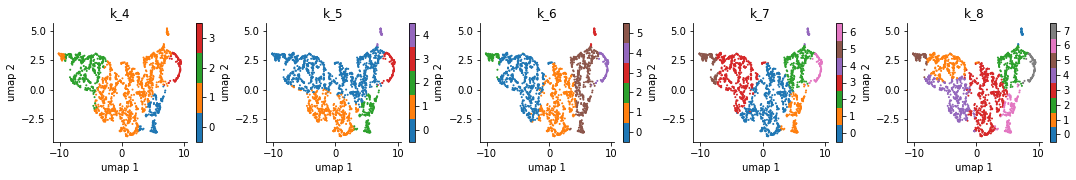

In [86]:
from plot_utils import plot_scatter_discrete, get_sim_color_map

methods = df.columns
fig, axes = plt.subplots(1, len(methods), figsize=(3*len(methods),2.6))    
for i, met in enumerate(methods):
    ax = axes[i]
    lut = get_sim_color_map(df[met], palette='tab10')
    plot_scatter_discrete(embedding, 
                          df[met], cols=lut,
                          ax=ax, ms=1)
    ax.set_title(met)
    ax.set_xlabel('umap 1')
    ax.set_ylabel('umap 2')
plt.tight_layout()
plt.show()

In [67]:
from main_methods import graph_eig_decomp
nb_clusters, eigenvalues, eigenvectors = graph_eig_decomp(graph)

In [72]:
from main_methods import optimalK
A = graph
n_eigs = 25
L = csgraph.laplacian(A)
eigenvalues, eigenvectors = eigsh(L, which='SM', k=n_eigs)

In [ ]:
from sklearn.cluster import KMeans


In [98]:
eigenvectors

array([[ 0.01204557,  0.00340757, -0.00770065, ...,  0.00536565,
        -0.00954774,  0.02175014],
       [ 0.01204557, -0.00802184, -0.00607872, ..., -0.0020426 ,
        -0.00284457,  0.0090999 ],
       [ 0.01204557,  0.01027258, -0.00303398, ...,  0.00661326,
         0.0139649 , -0.00586716],
       ...,
       [ 0.01204557, -0.00399087, -0.00648253, ...,  0.00704285,
         0.00053429, -0.00509528],
       [ 0.01204557, -0.02027602,  0.02143195, ...,  0.00228366,
         0.00712646,  0.00037126],
       [ 0.01204557, -0.00569822, -0.00046258, ..., -0.00226985,
         0.03502569, -0.00775305]])

In [91]:
from sklearn.cluster import spectral_clustering
df = pd.DataFrame()
for n_clust in [4, 5, 6, 7, 8]:
    labs = spectral_clustering(graph, n_clusters=n_clust,
                               n_components=n_clust)
    name = 'k_{}'.format(n_clust)
    df[name] = labs
    print(name)

k_4
k_5
k_6
k_7
k_8


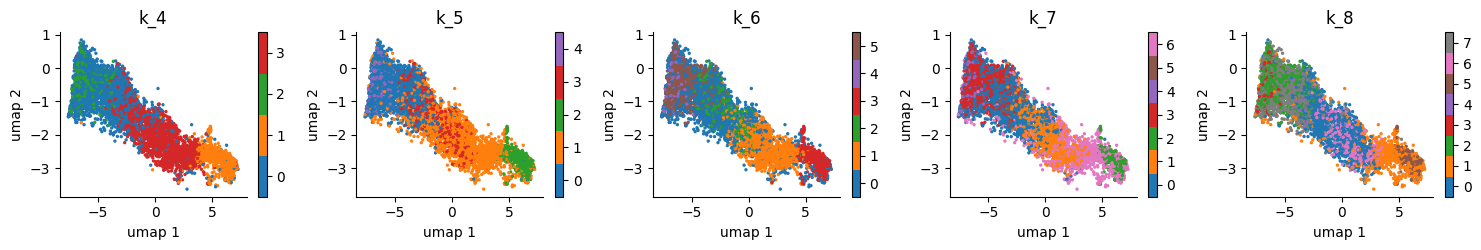

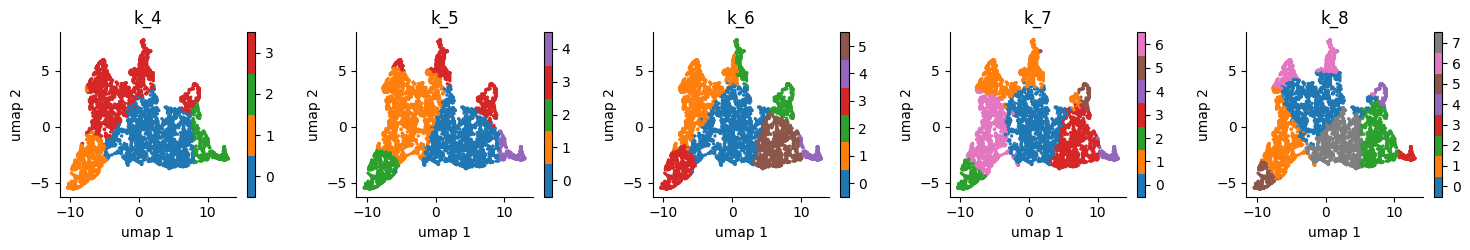

In [96]:
from plot_utils import plot_scatter_discrete, get_sim_color_map
sel_list = ['all', 'rejected']
methods = df.columns
for dat in ['expression', 'coefficient']:
    fig, axes = plt.subplots(1, len(methods), figsize=(3*len(methods),2.6))    
    for i, met in enumerate(methods):
        embedding = embed_dict["{}_{}".format('rejected', dat)]
        ax = axes[i]
        lut = get_sim_color_map(df[met], palette='tab10')
        plot_scatter_discrete(embedding, 
                              df[met], cols=lut,
                              ax=ax, ms=2)
        ax.set_title(met)
        ax.set_xlabel('umap 1')
        ax.set_ylabel('umap 2')
    plt.tight_layout()
    plt.show()

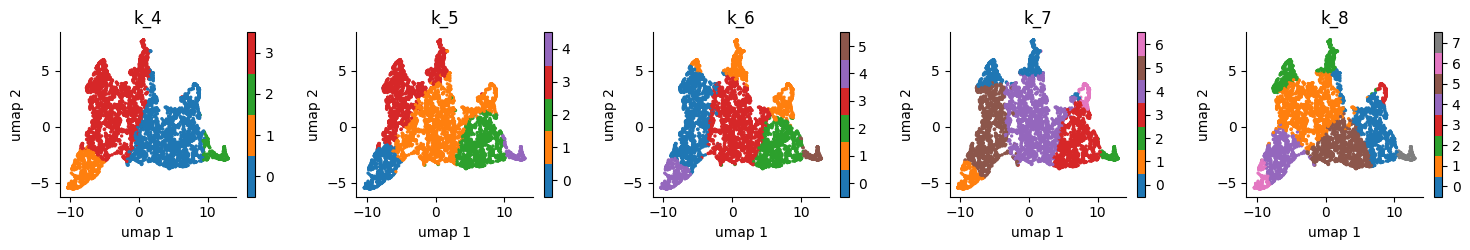

In [90]:
from plot_utils import plot_scatter_discrete, get_sim_color_map
sel_list = ['all', 'rejected', 'trim']
methods = df.columns
fig, axes = plt.subplots(1, len(methods), figsize=(3*len(methods),2.6))    
for i, met in enumerate(methods):
    ax = axes[i]
    lut = get_sim_color_map(df[met], palette='tab10')
    plot_scatter_discrete(embedding, 
                          df[met], cols=lut,
                          ax=ax, ms=2)
    ax.set_title(met)
    ax.set_xlabel('umap 1')
    ax.set_ylabel('umap 2')
plt.tight_layout()
plt.show()

array([3, 2, 1, ..., 2, 0, 1], dtype=int32)

In [80]:
k, gapdf = optimalK(eigenvectors[:,1:], maxClusters=25)

Optimal K = 24


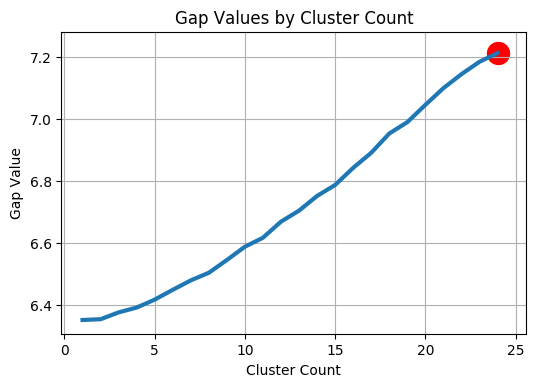

In [81]:
print('Optimal K = {}'.format(k))
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [68]:
nb_clusters

array([7, 5, 1, 2, 4])

In [18]:
from graph_utils import get_laplacian
from scipy.linalg import eigh
L = get_laplacian(graph.toarray())
evals, evecs = eigh(L) 

In [24]:
np.argsort(np.diff(evals[:100]))[::-1][:5]+1

array([10, 44,  7,  5, 19])

In [62]:
from scipy.sparse import csgraph
from graph_utils import get_laplacian
L1 = csgraph.laplacian(graph)
L2 = get_laplacian(graph)
assert (L1 != L2).nnz==0

In [63]:
from scipy.sparse.linalg import eigsh
eval1, evec1 = eigsh(L2, which = 'SM', k=10)

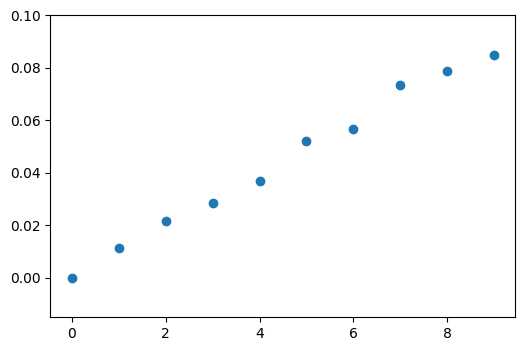

In [64]:
plt.scatter(np.arange(len(eval1)), eval1)

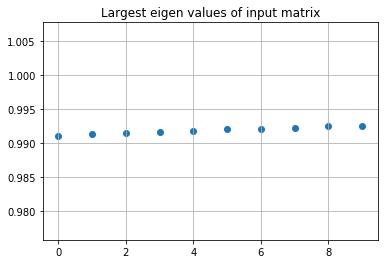

In [25]:
from main_methods import graph_eig_decomp
nb_clusters, eigenvalues, eigenvectors = graph_eig_decomp(graph)
plt.title('Largest eigen values of input matrix')
plt.scatter(np.arange(10), eigenvalues[:10])
plt.grid()

In [15]:
nb_clusters

array([24, 14, 18, 33,  8])

In [ ]:
plt.title('Largest eigen values of input matrix')
plt.scatter(np.arange(len(eigvals)), eigvals)
plt.grid()

In [ ]:
index_largest_gap = np.argsort(np.diff(eigvals))[::-1][:topK]

In [21]:
from main_methods import graph_eig_decomp
# check for symmetry
assert (graph != np.transpose(graph)).nnz==0
# nb_clusters, eigenvalues, eigenvectors = graph_eig_decomp(g.toarray())
print(nb_clusters)

[48 78 93 11 16]


In [50]:
np.transpose(g)

<6892x6892 sparse matrix of type '<class 'numpy.float64'>'
	with 118310 stored elements in Compressed Sparse Column format>

In [94]:
from main_methods import compute_all_embeddings
from intestine_info import load_gene_set_clusters
from main_methods import compute_embedding
from general_utils import norm_mtx
kmtx, kdf = load_gene_set_clusters(var_df)

embed_dict = compute_all_embeddings(result, c_mtx, mtx)
display(kdf.head())
moor = compute_embedding(kmtx)
ours = compute_embedding(c_mtx[kdf['orig_idx'], :])
naive = compute_embedding(mtx[:, kdf['orig_idx']].T)
naive['umap 1'] = -naive['umap 1']
ours['umap 2'] = -ours['umap 2']
embed_dict['trim_expression'] = naive
embed_dict['trim_moor'] = moor
embed_dict['trim_coefficient'] = ours
print(embed_dict.keys())

Computing embedding for: all_coefficient
input dimension: (9656, 5)
Computing embedding for: all_expression
input dimension: (9656, 1383)
Computing embedding for: rejected_coefficient
input dimension: (6892, 5)
Computing embedding for: rejected_expression
input dimension: (6892, 1383)


,indin,clust_idx,curr_idx,orig_idx
gene_name,,,,
Mrpl15,8,1,0,0
Lypla1,9,3,1,1
Arfgef1,40,3,2,14
Tram1,52,1,3,16
Rpl7,63,4,4,20


input dimension: (2118, 7)
input dimension: (2118, 5)
input dimension: (2118, 1383)
dict_keys(['all_coefficient', 'all_expression', 'rejected_coefficient', 'rejected_expression', 'trim_expression', 'trim_moor', 'trim_coefficient'])


In [40]:
save_data_to_file(embed_dict, fns['embed_dict'], 'pkl')

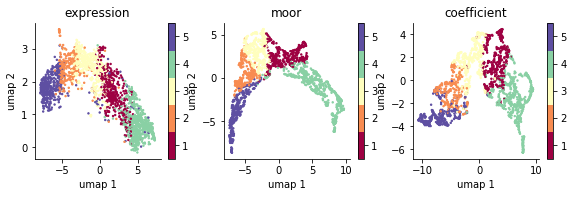

In [35]:
from plot_utils import plot_scatter_discrete
methods = ['expression', 'moor', 'coefficient']
var_labs = kdf['clust_idx']
fig, axes = plt.subplots(1, len(short_embed), figsize=(3.2*len(short_embed),2.5))
data_grp = 'trim'
for i, m in enumerate(methods):
    df = embed_dict['{}_{}'.format(data_grp, m)]
    ax = axes[i]
    plot_scatter_discrete(df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=2)
    ax.set_title(m)
    ax.set_xlabel('umap 1')
    ax.set_ylabel('umap 2')
plt.show()

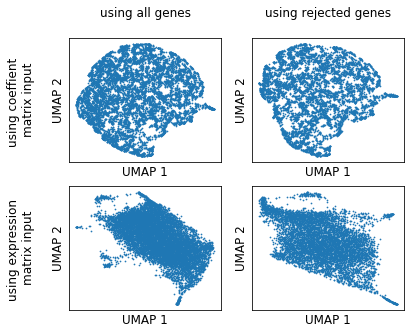

In [17]:
# plot the embeddings
fontsize = 12
sel_list = ["all", "rejected"]
mat_list = ["coeffient", "expression"]
fig, axes = plt.subplots(len(sel_list), len(mat_list), figsize=(3*len(mat_list), 2.5*len(sel_list)))
for i, sel in enumerate(sel_list):
    for j, mat in enumerate(mat_list):
        plt_df = embed_dict["{}_{}".format(sel, mat)]
        ax = axes[j, i]
        x = plt_df['umap 1']
        y = plt_df['umap 2']
        ax.scatter(x, y, s=0.5)
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlabel("UMAP 1", fontsize=fontsize)
        if j == 0:
            ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
        if i == 0:
            ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
        else:
            ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
plt.show()